In [1]:
import numpy as np
from qiskit import *
from qiskit.quantum_info.operators import Operator, Pauli
from qiskit.tools.visualization import plot_histogram

In [2]:
c = QuantumCircuit(2,2)
c.h(0)
c.h(1)
Grov = Operator([[1, 0,  0, 0], 
                 [0, 1,  0, 0], 
                 [0, 0, -1, 0], 
                 [0, 0,  0, 1]])
c.append(Grov,[0,1])

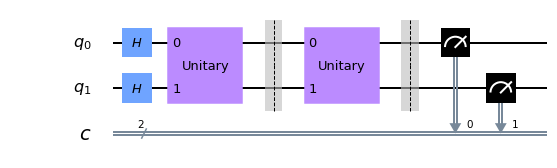

In [3]:
c.barrier()
MeanInv = Operator([[-1/2,  1/2,  1/2,  1/2], 
                    [ 1/2, -1/2,  1/2,  1/2], 
                    [ 1/2,  1/2, -1/2,  1/2], 
                    [ 1/2,  1/2,  1/2, -1/2]])
c.append(MeanInv,[0,1])
c.barrier()
c.measure([0,1],[0,1])
c.draw(output='mpl')

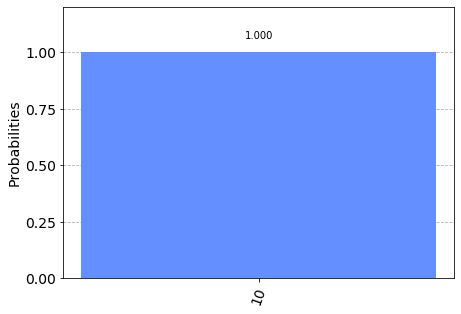

In [4]:
#simulate on qiskit aer
sim = Aer.get_backend('qasm_simulator')
res = execute(c, backend = sim, shots = 1024).result()

#writing something to plot the simulation results on a histogram
plot_histogram(res.get_counts(c))

In [5]:
#running on a real quantum device
IBMQ.load_account()
provider = IBMQ.get_provider('ibm-q')
qcomp = provider.get_backend('ibmq_ourense')
job = execute(c, backend=qcomp)
from qiskit.tools.monitor import job_monitor
job_monitor(job)

RequestsApiError: 401 Client Error: Unauthorized for url: https://auth.quantum-computing.ibm.com/api/users/loginWithToken. LOGIN_FAILED, Error code: LOGIN_FAILED.

In [ ]:
#plotting the results of the real computation
qres = job.result()
counts = qres.get_counts()
print('The run counts are:', counts)
plot_histogram([qres.get_counts(c), res.get_counts(c)], legend=['Device', 'Simulator'])

In [ ]:
#noise mitigation
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, CompleteMeasFitter)

cal_circuits, state_labels = complete_meas_cal(qr = c.qregs[0], circlabel = 'measerrormitcal')
cal_job = execute(cal_circuits,
                 backend = qcomp,
                 shots = 1024,
                 optimization_level = 0,
                 )

#this part runs the predefined calibration circuits for the circuit size and monitors the job
job_monitor(cal_job)
calres = cal_job.result()

#we use the calibration result to filter out our noisy results
meas_fitter = CompleteMeasFitter(calres, state_labels)

#filtering out noise from the quantum result
meas_fitter.plot_calibration()
meas_filter = meas_fitter.filter
mitres = meas_filter.apply(qres)

In [ ]:
#plotting the sim vs noisy results vs mitigated results
qcounts = qres.get_counts(c)
mitcounts = mitres.get_counts(c)
plot_histogram([counts, qcounts, mitcounts], legend = ['sim', 'noisy results', 'mitigated results'])